<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install tqdm
!pip install accelerate
!pip install einops

In [1]:
import torch
import math
import numpy as np
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import time
import numpy
import pickle
import os
# import lpips

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from scipy.linalg import sqrtm
from functools import partial
from ipdb import set_trace as st
from accelerate import Accelerator
from datasets import load_dataset
from einops import rearrange

from torch import nn
from torch import optim
from torch import autocast
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_tensor, resize
from torchvision import transforms
from torchvision.transforms import v2, InterpolationMode
# from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF

from miniai.datasets import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from google.colab import drive
drive.mount('/content/drive')

mpl.rcParams['image.cmap'] = 'gray_r'

set_seed(42)
mdl_path = Path('drive/MyDrive/fastai_p2/models/')

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
class BaseSchedulerCB(Callback):
  def __init__(self, sched_class): self.sched_class = sched_class
  def before_fit(self, learn): self.sched = self.sched_class(learn.opt)
  def step(self, learn):
    if not learn.training: return
    self.sched.step()

class BatchSchedulerCB(BaseSchedulerCB):
  def __init__(self, sched_class):super().__init__(sched_class)
  def after_batch(self, learn): self.step(learn)

In [3]:
dname, xn, yn = 'fashion_mnist', 'image', 'label'
dsd = load_dataset(dname)

@inplace
def transformi(b):
  b['image'] = [(resize(to_tensor(o), (28, 28), antialias = True)) for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size = 256, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
class DataPrepCB(Callback):
  def before_batch(self, learn):
    x, y = learn.batch
    nx = x.view(x.shape[0], -1)
    learn.batch = (nx, nx)

In [5]:
def lin(ni, nf):
  return nn.Sequential(
      nn.Linear(ni, nf),
      nn.ReLU(),
      nn.LayerNorm(nf)
  )

In [6]:
class AE(nn.Module):
  def __init__(self, ni = 784, nl = 100, nh = 256):
    super().__init__()
    self.enc = nn.Sequential(
        lin(ni, nh),
        lin(nh, nl)
    )
    self.dec = nn.Sequential(
        lin(nl, nh),
        lin(nh, ni)
    )

  def forward(self, x):
    return self.dec(self.enc(x))

loss,epoch,train
0.710,0,train
0.564,0,eval
0.418,1,train
0.253,1,eval
0.097,2,train
0.042,2,eval
0.036,3,train
0.032,3,eval
0.031,4,train
0.029,4,eval


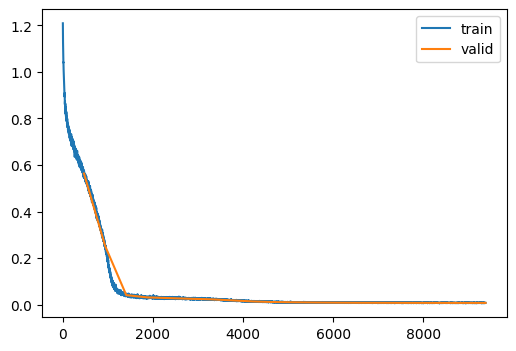

In [12]:
lr_max, epochs = 2e-03, 20
dls = DataLoaders.from_dd(tds, batch_size = 128, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          DataPrepCB(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
model =  AE()
learner = TrainLearner(model, dls, loss_func = F.mse_loss, lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-05))
learner.fit(epochs)

In [12]:
x, y = next(iter(dls.valid))

In [15]:
x.shape

torch.Size([256, 1, 28, 28])

In [16]:
out = model(x.view(256, -1).cuda())

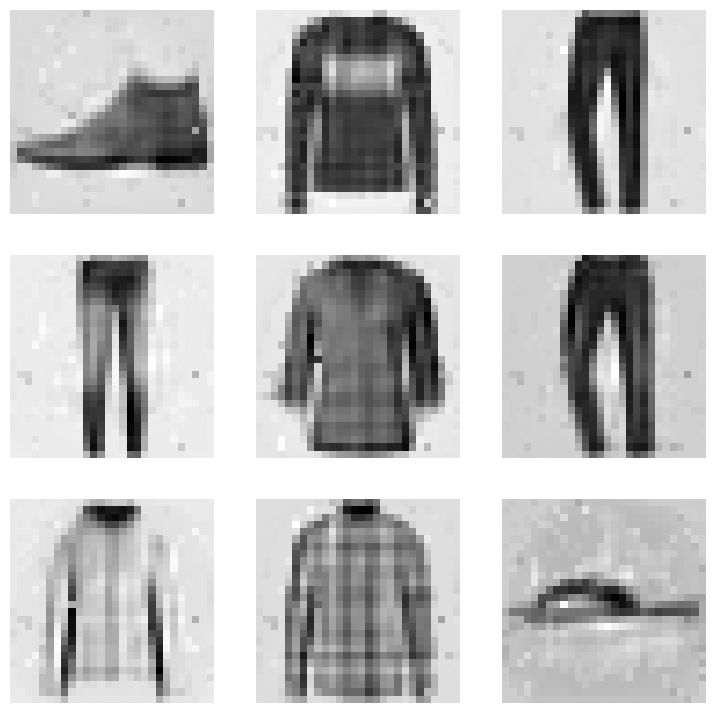

In [17]:
show_images(out.view(256, 1, 28, 28)[:9].cpu())

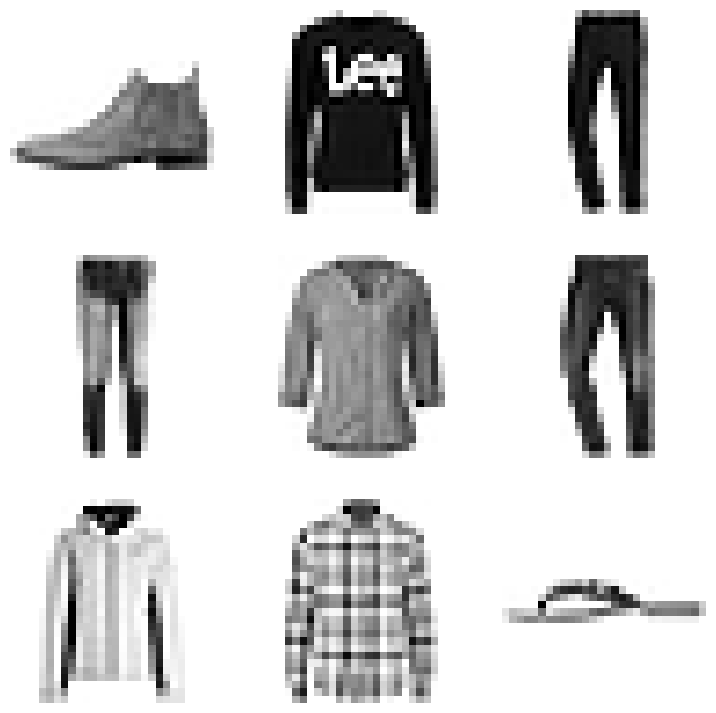

In [19]:
show_images(x[:9].cpu())

In [70]:
def lin(ni, nf, act = True, norm = True):
  layers = []
  if act: layers.append(nn.ReLU())
  if norm: layers.append(nn.LayerNorm(ni))
  layers.append(nn.Linear(ni, nf))
  return nn.Sequential(*layers)

class LinRes(nn.Module):
  def __init__(self, ni, no):
    super().__init__()
    self.l1 = lin(ni, no, act = False)
    self.l2 = nn.Sequential(lin(no, no), lin(no, no), lin(no, no))

  def forward(self, x):
    x = self.l1(x)
    return x + self.l2(x)

class VAE(nn.Module):
  def __init__(self, ni = 784, nl = 100, nh = [512, 256]):
    super().__init__()
    nh = [ni] + nh
    self.enc = nn.Sequential(*[LinRes(nh[i], nh[i+1]) for i in range(len(nh) - 1)])
    self.mu = LinRes(nh[-1], nl)
    self.lv = LinRes(nh[-1], nl)
    # st()
    rnh = [nl] + list(reversed(nh))
    self.dec = nn.Sequential(nn.Sequential(*[LinRes(rnh[i], rnh[i+1]) for i in range(len(rnh) - 1)]))

  def forward(self, x):

    x = self.enc(x)
    mu, lv = self.mu(x), self.lv(x)
    z = mu + torch.rand_like(mu)*torch.exp(0.5*lv)
    return self.dec(z), mu, lv

def kld_loss(out, targ):
  yhat, mu, lv = out
  return -0.5*(1 + lv - mu**2 - lv.exp()).mean()

def content_loss(out, targ):
  yhat, mu, lv = out
  return F.mse_loss(yhat, targ) + F.binary_cross_entropy_with_logits(yhat, targ)

def combined_loss(out, targ, beta = 0.8):
  return content_loss(out, targ) + beta*kld_loss(out, targ)

loss,epoch,train
1.159,0,train
0.811,0,eval
0.781,1,train
0.760,1,eval
0.753,2,train
0.749,2,eval
0.737,3,train
0.731,3,eval
0.730,4,train
0.723,4,eval


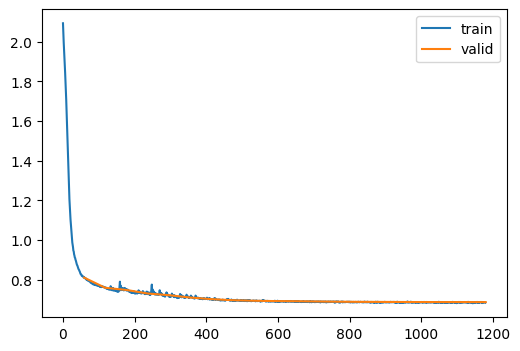

In [72]:
lr_max, epochs = 1e-03, 20
dls = DataLoaders.from_dd(tds, batch_size = 1024, num_workers=2)
cbs = [
          DeviceCB(torch.device('cuda')),
          MetricsCB(),
          ProgressCB(plot = True),
          DataPrepCB(),
          BatchSchedulerCB(partial(lr_scheduler.OneCycleLR, max_lr = lr_max, epochs = epochs, steps_per_epoch = len(dls.train))),
      ]
vmodel =  VAE(nh = [512, 376, 256], nl = 150)
learner = TrainLearner(vmodel, dls, loss_func = partial(combined_loss, beta = 0.8), lr = lr_max, cbs = cbs, opt_func = partial(torch.optim.AdamW, eps = 1e-04))
learner.fit(epochs)

In [73]:
x.shape

torch.Size([2048, 1, 28, 28])

In [74]:
out = vmodel(x.view(2048, -1).cuda())

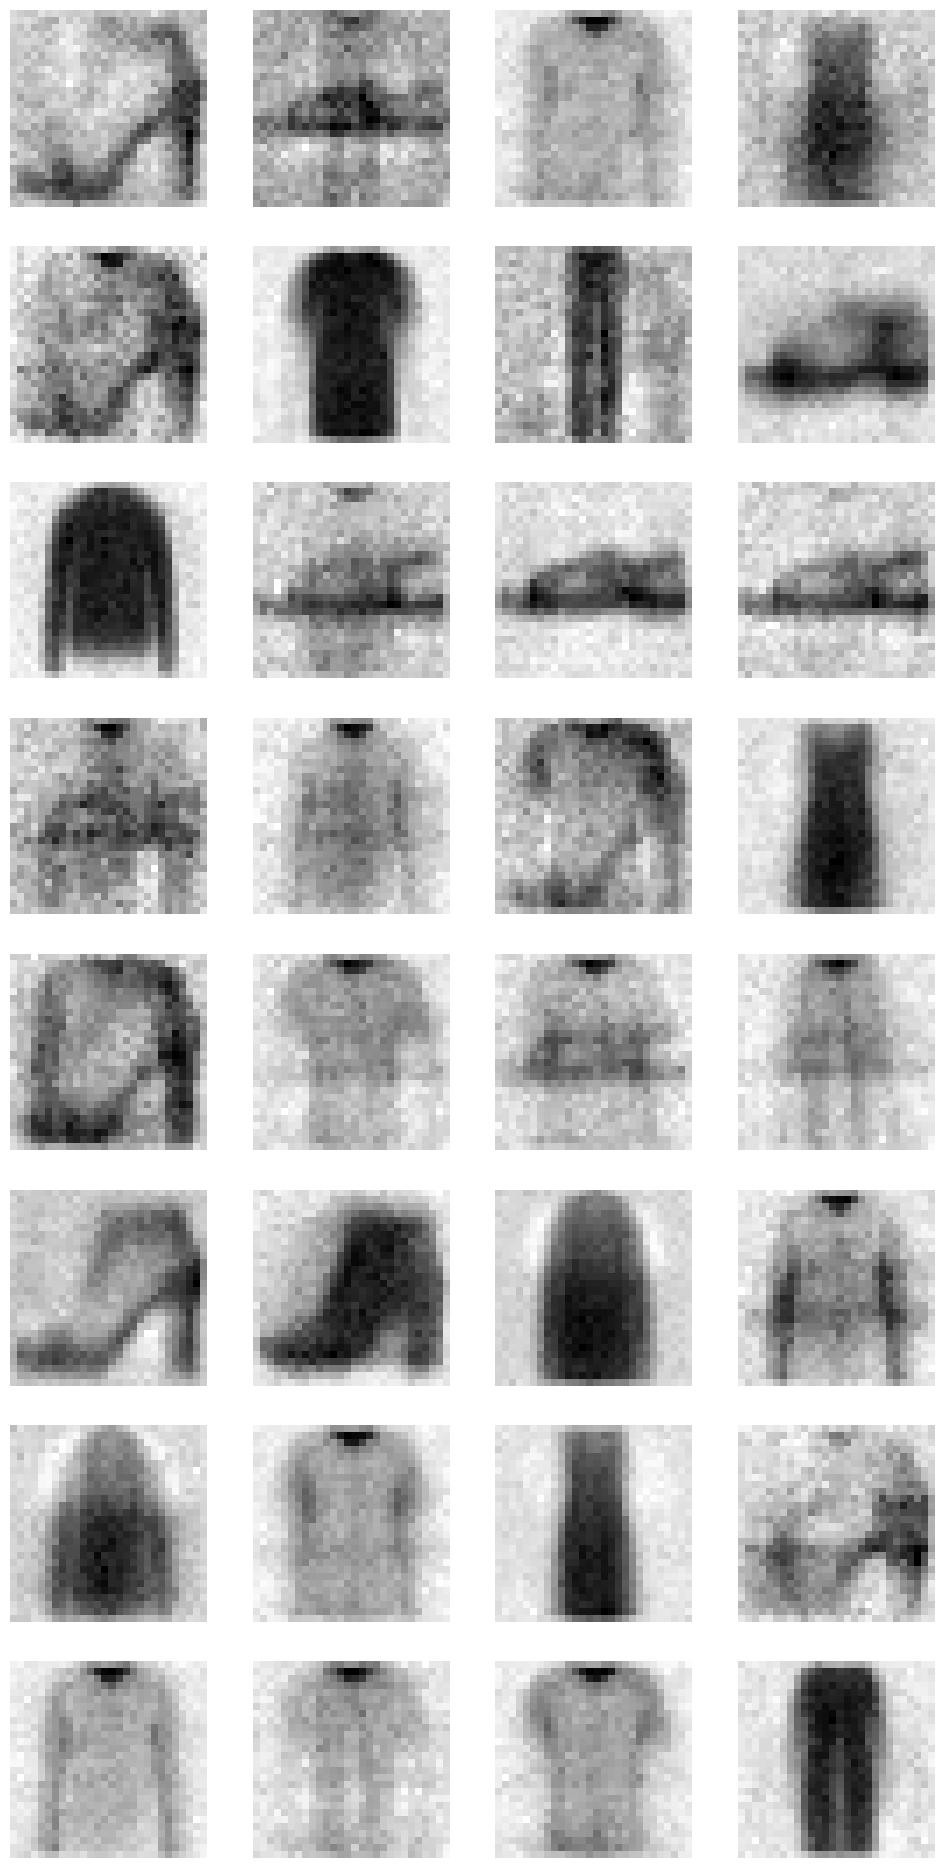

In [78]:
show_images(out[0].view(2048, 1, 28, 28)[:32].cpu(), ncols = 4)

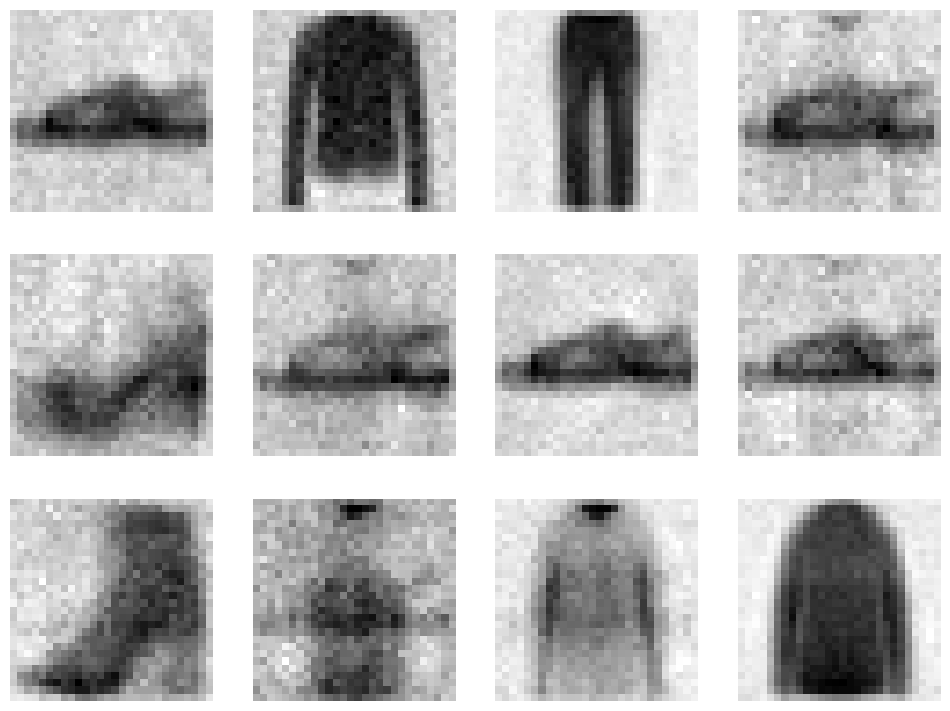

In [79]:
out = vmodel(torch.rand_like(x).view(2048, -1).cuda())
show_images(out[0].view(2048, 1, 28, 28)[:12].cpu())